In [ ]:

%pylab inline
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# TODO: fill in the path to downloaded qick repo".
qick_path = ''
sys.path.append(qick_path)

from qick import * 
import time 

# TODO: fill in the path to bitstream files.
bitfile_path = ''

soc = QickSoc(bitfile = bitfile_path)
soccfg = soc
print(soccfg)

In [3]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        style=self.cfg["pulse_style"]

        self.set_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain, 
                                 style=style, length=cfg["length"])

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):

        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        self.pulse(ch=self.cfg["res_ch"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

### Send/receive a pulse with <code> pulse_style </code> = <code> const </code>

In [4]:
config={"res_ch":6, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":20, # [Clock ticks]
        "readout_length":100, # [Clock ticks]
        "pulse_gain":3000, # [DAC units]
        "pulse_freq": 250, # [MHz]
        "adc_trig_offset": 100, # [Clock ticks]
        "soft_avgs":100

       }

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

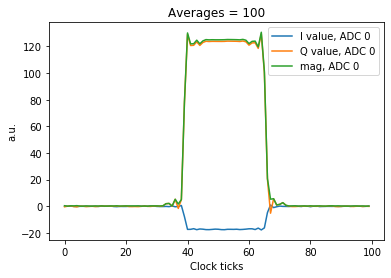

In [5]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();